In [72]:
import pandas as pd
import numpy as np
import os
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from screeninfo import get_monitors
from matplotlib.colors import ListedColormap
from matplotlib.patches import Circle
from pandas.api.types import CategoricalDtype
#04_analysis_osm_presence_igm_declaration.py

In [73]:
data = pd.read_parquet("data" + os.sep + "data_igm_provenance_osm_provincies.parquet")
data.rename(columns={'objects':'total_objects'},inplace=True)
data_italy = data.groupby(['name_it', 'name_en','layer_name']).agg({'osm_objects': 'sum','total_objects': 'sum'}).reset_index()
data_region = data.groupby(['region','name_it', 'name_en','layer_name']).agg({'osm_objects': 'sum','total_objects': 'sum'}).reset_index()
data_provincies = data.groupby(['province','name_it', 'name_en','layer_name']).agg({'osm_objects': 'sum','total_objects': 'sum'}).reset_index()

In [74]:
description_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRgAq3z8-cU_Fy88TUxteuTt_jsvUXIyFUFEbTrRuOXl2KFK-dbAgKAogJxUQtKkdPO5QzJm0M59Pw1/pub?gid=973898789&single=true&output=csv"
description_data = pd.read_csv(description_url)

In [75]:
# Specificare l'ordine delle categorie
categories_order = [
    'Geodetic information',
    'Cartographic and meta-information',
    'Roads',
    'Railways',
    'Other transport',
    'Buildings',
    'Man-made construction',
    'Transport infrastructure works',
    'Soil support and defence works',
    'Hydraulic, defence and hydraulic regulation works',
    'Inland and transitional waters',
    'Marine waters',
    'Glaciers and perennial snowfields',
    'Hydrographic network',
    'Altimetry',
    'Bathymetry',
    'Terrain forms',
    'Digital terrain models (tin, dem/dtm)',
    'Agro-forestry areas',
    'Urban greenery',
    'Water supply network',
    'Electricity network',
    'Gas distribution network',
    'Oil pipelines',
    'Significant locations',
    'Cartographic inscriptions',
    'Local authority administrative areas',
    'Transport services',
    'Pertinences',
    'Quarries-dumps'
]
cat_type = CategoricalDtype(categories=categories_order, ordered=True)


In [76]:
regions_label = ""
for r in data_region.region.unique():
    regions_label += r + " "


In [77]:
regions_label

'Abruzzo Basilicata Calabria Campania Lazio Marche Molise Puglia Sardegna Sicilia Toscana Umbria '

In [78]:
data_italy['percentage'] = round(data_italy['osm_objects'] / data_italy['total_objects'] * 100,3)
data_italy_with_osm = data_italy[data_italy.percentage >= 1]
data_italy_with_osm['missing'] = 100 - data_italy_with_osm['percentage']
data_italy_with_osm = data_italy_with_osm.sort_values(by='percentage', ascending=False)

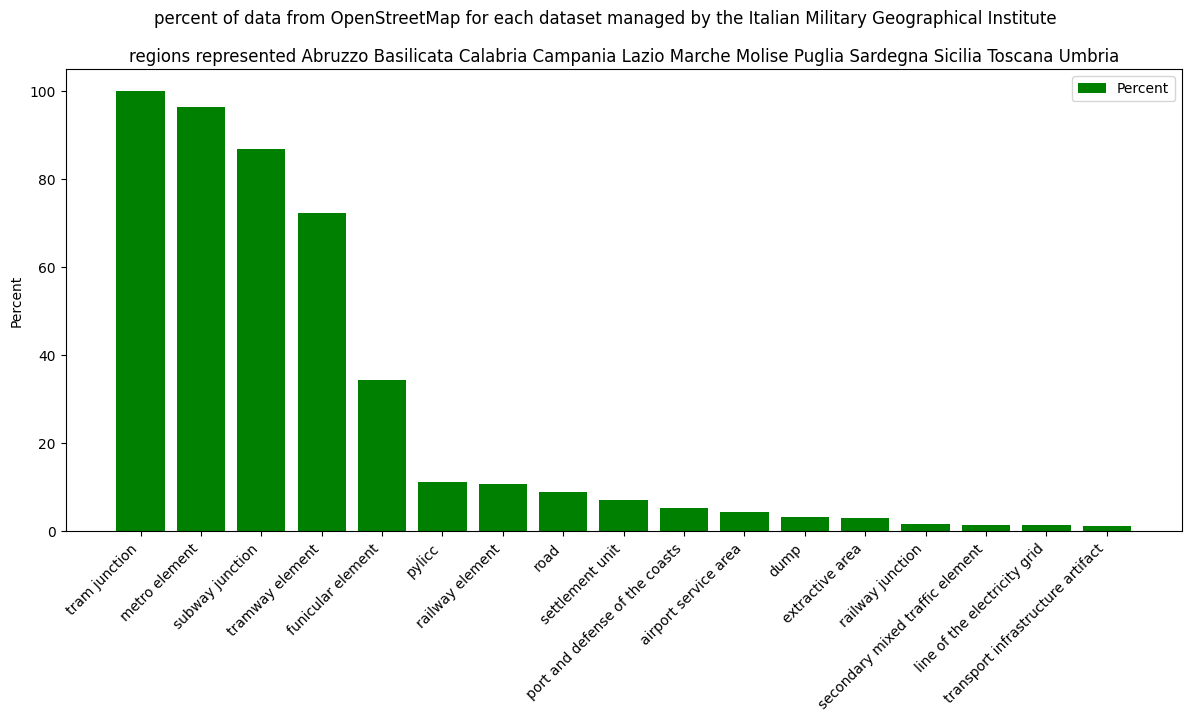

<Figure size 640x480 with 0 Axes>

In [102]:
monitor_width = int(get_monitors()[0].width)
fig, ax = plt.subplots(figsize=(monitor_width/100, 6))
plt.bar(data_italy_with_osm['name_en'], data_italy_with_osm['percentage'], color='g', label='Percent')
#plt.bar(data_italy_with_osm['name_en'], data_italy_with_osm['missing'], bottom=data_italy_with_osm['percentage'], color='g', label='Missing')
#plt.xlabel('Items')
plt.ylabel('Percent')
ax.set_xticks(range(len(data_italy_with_osm)))
ax.set_xticklabels(data_italy_with_osm['name_en'], rotation=45, ha='right')
plt.legend()
plt.suptitle("percent of data from OpenStreetMap for each dataset managed by the Italian Military Geographical Institute")
plt.title("regions represented " + regions_label.rstrip())
plt.show()
plt.savefig('image/percent_osm_dataset_igm.jpg', dpi=300)


In [80]:
data_regione_with_osm_data = data_region[data_region.osm_objects > 0]
data_regione_with_osm_data['percentage'] = round(data_regione_with_osm_data['osm_objects'] / data_regione_with_osm_data['total_objects'] * 100,3)
data_regione_with_osm_data[data_regione_with_osm_data.percentage >= 1]

,region,name_it,name_en,layer_name,osm_objects,total_objects,percentage
6,Abruzzo,area a servizio del trasporto su ferro,area of ​​transport on iron transport,sv_fer,1,81,1.235
51,Abruzzo,manufatto d'infrastruttura di trasporto,transport infrastructure artifact,man_tr,6,76,7.895
59,Abruzzo,opera portuale e di difesa delle coste,port and defense of the coasts,op_por,29,579,5.009
73,Abruzzo,unità insediativa,settlement unit,pe_uins,32,1328,2.410
144,Basilicata,tratto di linea della rete elettrica,line of the electricity grid,tr_ele,20,1551,1.289
...,...,...,...,...,...,...,...
862,Umbria,giunzione ferroviaria,railway junction,gz_fer,4,199,2.010
871,Umbria,manufatto d'infrastruttura di trasporto,transport infrastructure artifact,man_tr,3,40,7.500
886,Umbria,sostegno a traliccio,pylicc,tralic,1928,29308,6.578
892,Umbria,tratto stradale,road,tr_str,60799,63073,96.395


In [81]:
data_regione_with_osm_data['category_en'] = data_regione_with_osm_data.layer_name.apply(lambda x: description_data[description_data.layer_name == x]['category_en'].values[0])

In [82]:
data_regione_with_osm_data['category_en'] = data_regione_with_osm_data['category_en'].astype(cat_type)

In [83]:
data_regione_with_osm_data_category = data_regione_with_osm_data.groupby(['region','category_en']).agg({'osm_objects': 'sum', 'total_objects': 'sum'})

In [84]:
data_regione_with_osm_data_category['percent_in_osm'] = round((data_regione_with_osm_data_category['osm_objects'] / data_regione_with_osm_data_category['total_objects']) * 100,2)

In [85]:
data_regione_with_osm_data_category

osm_objects  total_objects  \
region  category_en                                                        
Abruzzo Geodetic information                            0              0   
        Cartographic and meta-information               0              0   
        Roads                                           7         506875   
        Railways                                        0              0   
        Other transport                                 0              0   
...                                                   ...            ...   
Umbria  Cartographic inscriptions                       0              0   
        Local authority administrative areas            0              0   
        Transport services                              1             16   
        Pertinences                                   261           1381   
        Quarries-dumps                                 10            132   

                                              percent_in_osm  
region  category_en                                           
Abruzzo Geodetic information                             NaN  
        Cartographic and meta-information                NaN  
        Roads                                           0.00  
        Railways                                         NaN  
        Other transport                                  NaN  
...                                                      ...  
Umbria  Cartographic inscriptions                        NaN  
        Local authority administrative areas             NaN  
        Transport services                              6.25  
        Pertinences                                    18.90  
        Quarries-dumps                                  7.58  

[360 rows x 3 columns]

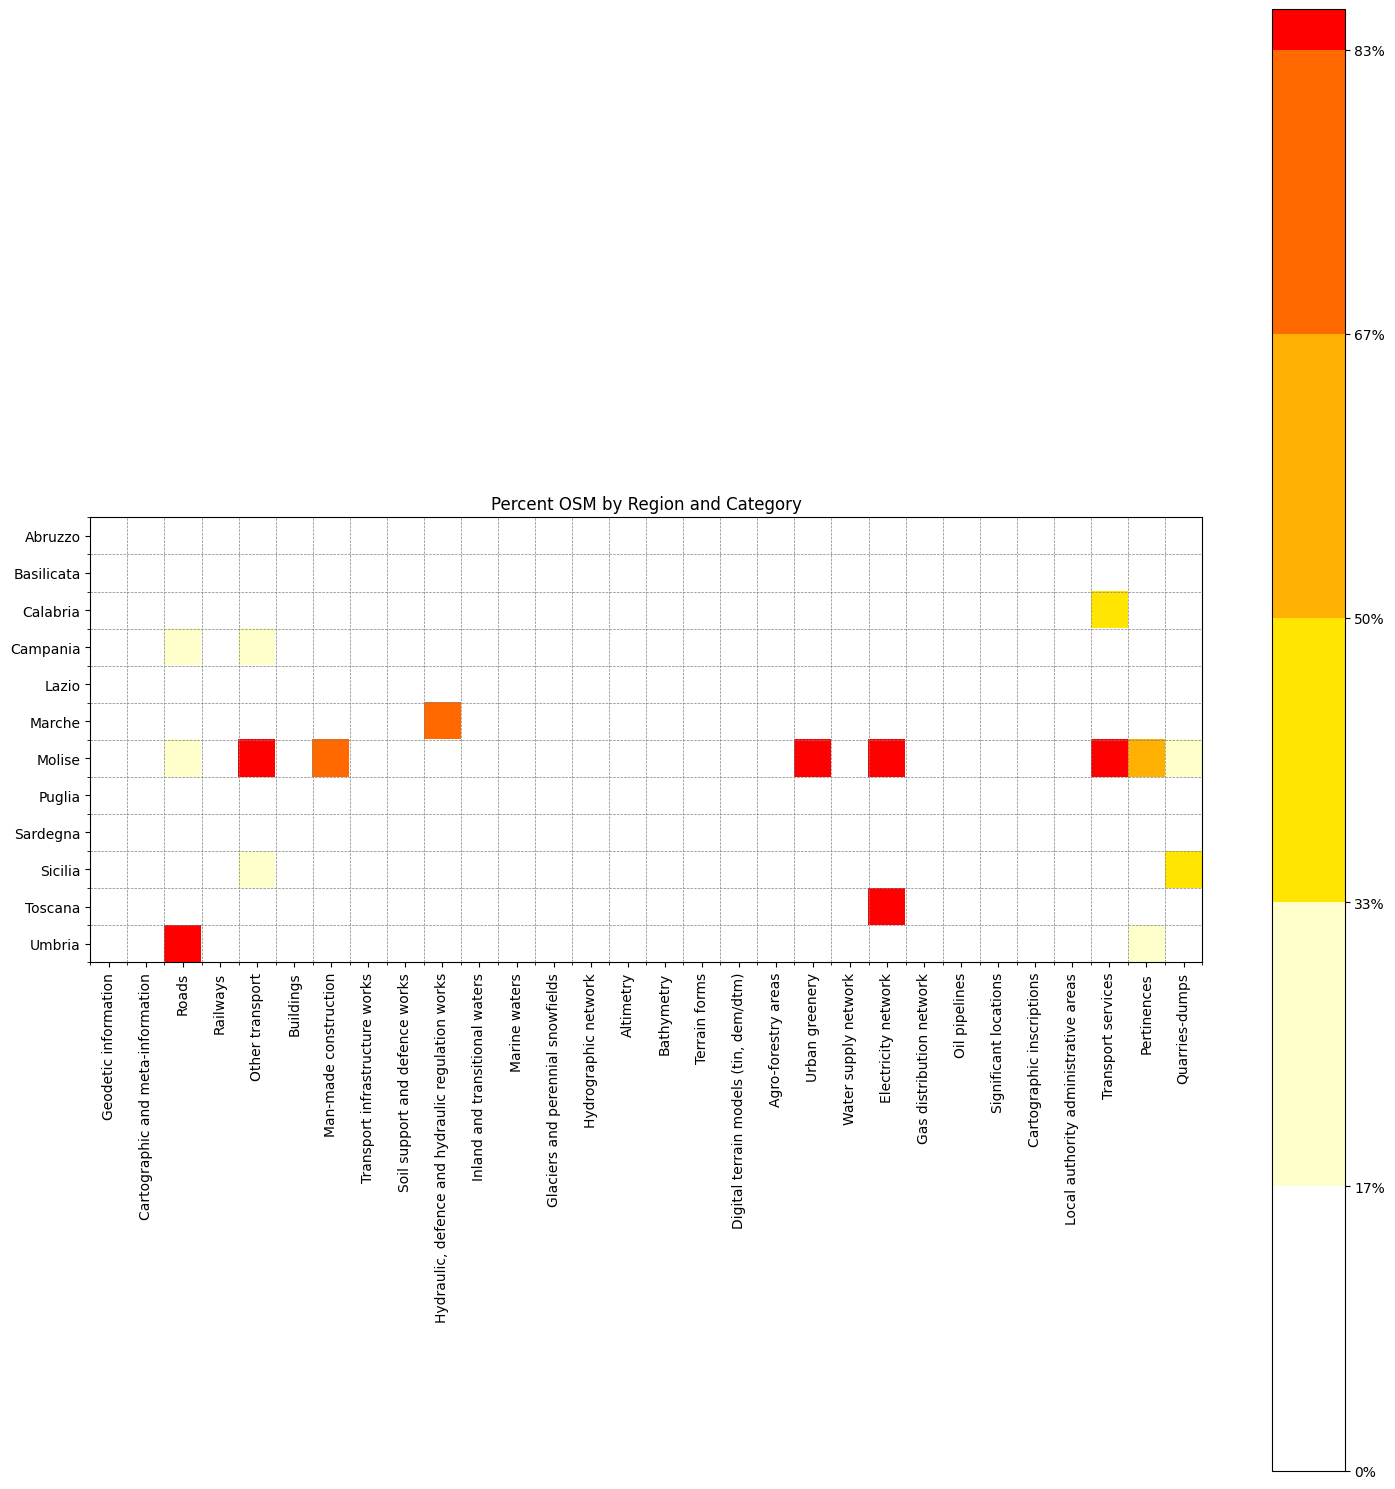

In [86]:
# Creiamo un array numpy 2D con i valori di percent_osm per ogni combinazione di region e macrocategory_en
regions = data_regione_with_osm_data_category.index.levels[0]
categories = data_regione_with_osm_data_category.index.levels[1]
values = np.zeros((len(regions), len(categories)))
for i, region in enumerate(regions):
    for j, category in enumerate(categories):
        try:
            value = data_regione_with_osm_data_category.loc[(region, category), 'percent_in_osm']
            if not np.isnan(value):
                values[i, j] = value
        except KeyError:
            value = 0
            if not np.isnan(value):
                values[i, j] = value


# Creiamo la matrice di colori personalizzata
colors = ['#FFFFFF', '#FFFFCC', '#FFE500', '#FFB000', '#FF6900', '#FF0000']
cmap = ListedColormap(colors)

# Creiamo un oggetto figura e un oggetto assi
fig, ax = plt.subplots(figsize=(15, 15))

# Creiamo un'immagine a colori della matrice di valori
im = ax.imshow(values, cmap=cmap, vmax=100)

# Aggiungiamo la griglia
ax.set_xticks(np.arange(len(categories)+1)-0.5, minor=True)
ax.set_yticks(np.arange(len(regions)+1)-0.5, minor=True)
ax.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)

# Aggiungiamo le etichette delle righe e delle colonne
ax.set_xticks(np.arange(len(categories)))
ax.set_xticklabels(categories, rotation='vertical')
ax.set_yticks(np.arange(len(regions)))
ax.set_yticklabels(regions)

# Aggiungiamo il titolo del grafico e la barra con la legenda
ax.set_title('Percent OSM by Region and Category')
cbar = plt.colorbar(im, ax=ax)
ticks = np.linspace(0, 100, len(colors) + 1)
cbar.ax.set_yticks(ticks)
cbar.ax.set_yticklabels([f"{x:.0f}%" for x in ticks])
#cbar.ax.set_xticklabels([f"{x:.0f}%" for x in np.linspace(0, 100, len(colors) + 1)[:-1]])

# Posizioniamo i tick della barra della legenda a destra e aggiungiamo l'etichetta della barra della legenda
cbar.ax.yaxis.set_ticks_position('right')
#cbar.ax.set_ylabel('Percentuale OSM')

# Impostiamo l'altezza della barra della legenda
cbar.ax.set_ylim(0, 100 * (len(colors) / (len(colors) + 1)))

# Allarghiamo il grafico
fig.tight_layout()

# Salviamo il grafico come immagine
plt.savefig('image/percent_osm_by_region_and_category.png', dpi=300)

# Mostrare il grafico
plt.show()

In [87]:
# Esportiamo la griglia generata dal grafico in un formato csv
percente_osm_category_by_region = pd.DataFrame(values, index=regions, columns=categories)
percente_osm_category_by_region.to_csv('data/percente_osm_category_by_region.csv')

In [88]:
data_provincies_with_osm_data = data_provincies[data_provincies.osm_objects > 0]
data_provincies_with_osm_data['percentage'] = round(data_provincies_with_osm_data['osm_objects'] / data_provincies_with_osm_data['total_objects'] * 100,3)
data_provincies_with_osm_data = data_provincies_with_osm_data[data_provincies.osm_objects > 0]

/tmp/ipykernel_7420/1859529673.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_provincies_with_osm_data = data_provincies_with_osm_data[data_provincies.osm_objects > 0]


In [89]:
data_provincies_with_osm_data['macrocategory_en'] = data_provincies_with_osm_data.layer_name.apply(lambda x: description_data[description_data.layer_name == x]['macro_category_en'].values[0])

In [90]:
data_provincies_with_osm_data

,province,name_it,name_en,layer_name,osm_objects,total_objects,percentage,macrocategory_en
29,Ancona,edificio,building,edifc,254,113247,0.224,Buildings and human settlements
30,Ancona,edificio minore,minor building,edi_min,1,1170,0.085,Buildings and human settlements
34,Ancona,elemento di viabilità mista secondaria,secondary mixed traffic element,el_vms,51,14267,0.357,"Roads, mobility and transport"
35,Ancona,elemento ferroviario,railway element,el_fer,1,939,0.106,"Roads, mobility and transport"
59,Ancona,opera portuale e di difesa delle coste,port and defense of the coasts,op_por,124,188,65.957,Buildings and human settlements
...,...,...,...,...,...,...,...,...
4338,Viterbo,area estrattiva,extractive area,cv_aes,20,91,21.978,Appurtenant areas
4356,Viterbo,edificio minore,minor building,edi_min,18,81192,0.022,Buildings and human settlements
4397,Viterbo,tratto di linea della rete elettrica,line of the electricity grid,tr_ele,1,17714,0.006,Underground utility networks
4398,Viterbo,tratto stradale,road,tr_str,6,25345,0.024,"Roads, mobility and transport"


In [91]:
#data_provincies_with_osm_data[data_provincies_with_osm_data['province'] == 'Ragusa'].sort_values(by="percentage", ascending=False)

In [92]:
#data_regione_with_osm_data[data_regione_with_osm_data['region'] == 'Sicilia'].sort_values(by="percentage", ascending=False)

In [93]:
#data_regione_with_osm_data.region.unique()

In [94]:
data_italy['macrocategory_en'] = data_italy.layer_name.apply(lambda x: description_data[description_data.layer_name == x]['macro_category_en'].values[0])

In [95]:
data_italy

,name_it,name_en,layer_name,osm_objects,total_objects,percentage,macrocategory_en
0,acqua interna,internal water,acq_in,0,3065,0.000,Administrative areas
1,acqua territoriale,territorial water,acq_ter,0,37,0.000,Administrative areas
2,affioramento naturale dell'acqua,natural outcrop of water,af_acq,0,17224,0.000,Hydrography
3,alveo,riverbed,alveo,0,4426,0.000,Orography
4,ambito omogeneo per la metainformazione,homogeneous scope for metainformation,meta,0,6516,0.000,Geodetic and photogrammetric information
...,...,...,...,...,...,...,...
71,tratto di linea della rete elettrica,line of the electricity grid,tr_ele,5073,361992,1.401,Underground utility networks
72,tratto stradale,road,tr_str,269872,2999288,8.998,"Roads, mobility and transport"
73,unità insediativa,settlement unit,pe_uins,3077,43700,7.041,Appurtenant areas
74,vertice di rete,network vertex,v_rete,0,18657,0.000,Geodetic and photogrammetric information


In [96]:
data_italy_macrocategory = data_italy.groupby('macrocategory_en').agg({'osm_objects': 'sum', 'total_objects': 'sum'})
data_italy_macrocategory['percent_osm'] = round((data_italy_macrocategory['osm_objects'] / data_italy_macrocategory['total_objects'] * 100),2)

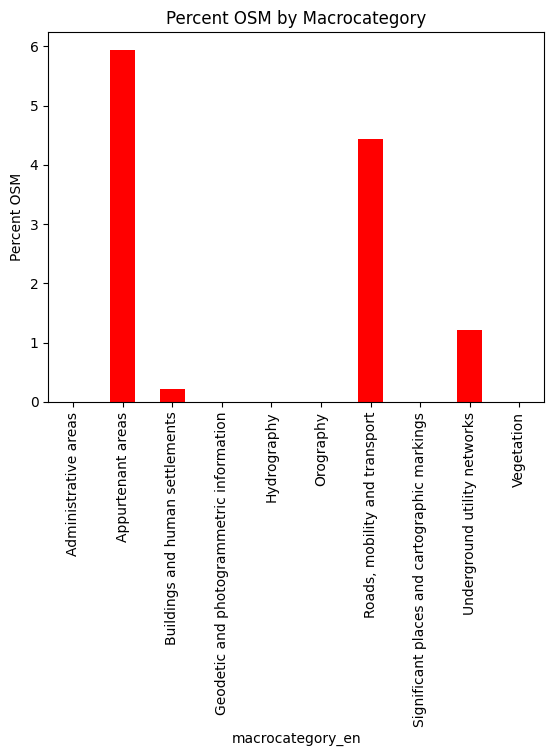

In [97]:
# Creiamo un grafico a barre solo per percent_osm
fig, ax = plt.subplots()
data_italy_macrocategory.plot.bar(y='percent_osm', ax=ax, color='red', legend=False)

# Aggiungiamo le etichette delle assi e il titolo del grafico
ax.set_xlabel('macrocategory_en')
ax.set_ylabel('Percent OSM')
ax.set_title('Percent OSM by Macrocategory')

# Mostrare il grafico
plt.show()